<a href="https://colab.research.google.com/github/yehuda-yu/Remote_sensing_projects/blob/main/read_netcdf_image_as_data_cube.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [11]:
ds = xr.open_dataset("/content/drive/MyDrive/gdrive_folder/Courses/Remote_Sensing/HRSEVIRI_20210301T095700Z_20210301T095700Z_epct_1def9dca_F.nc")

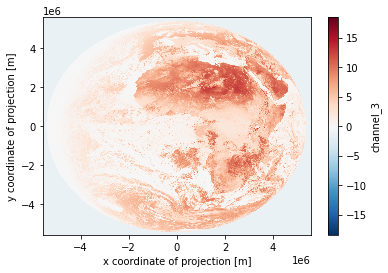

In [12]:
x = ds["channel_3"]
x.plot()

In [13]:
# x   = x.values

# chose channels {these are the real attribute names of the MSG NetCDF layers}
chl =["channel_1","channel_2","channel_3","channel_4","channel_5","channel_6","channel_7","channel_8","channel_9","channel_10","channel_11"]
# create an empty array
array = []
# loop over channels and get them into the array
for i in chl:
  array.append(np.flipud(ds[i]))
data = np.stack((array),axis=0)
# print shape of the array
print(data.shape)

(11, 3712, 3712)


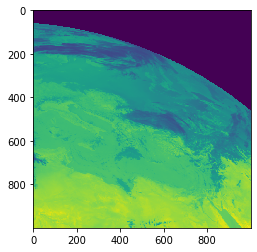

In [20]:
sub_data = data[:,0:1000:, 2000:3000] # get a chunk of the total area
# create new array with name "band":
band=sub_data[9]
# display small array:
plt.imshow(band, interpolation='none')
plt.show()

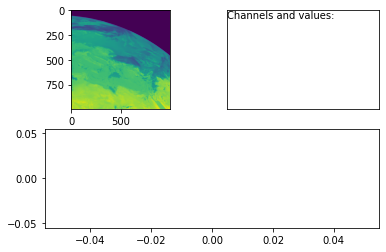

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig, ax = plt.subplots(2,2)

ax[0,1].grid(False)
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[1,1].remove()

gs      = gridspec.GridSpec(2,2)
ax[1,0] = plt.subplot(gs[1,:])
textbox = 'Channels and values:'
ax[0,1].text(0.0,1.0,textbox, fontsize=10, verticalalignment='top')

im = band
x  = np.array([0, 1, 2, 3 ])
y  = np.array([3, 8, 1, 10])

implot = ax[0,0].imshow(im)

ax[1,0].plot([0,0,0], [0,0,0])

def onclick(event):
   if event.xdata != None and event.ydata != None:
       x = event.xdata
       y = event.ydata
       # We need to select a single layer (channel) from the 3-D array: 
       t = sub_data[:,int(y),int(x)]
       round = np.around(t, 11) 

       # text =============================================================== #
       # Clear axis
       ax[0,1].clear()
       ax[0,1].grid(False)
       ax[0,1].set_xticks([])
       ax[0,1].set_yticks([])

       # Write new text
       textbox = 'Wavelength [\u00b5m]      Irr [mW m$^{-2}$ (cm$^{-1}$)$^{-1}$]'  + \
        '  \n' + '----------------------------------------------------------'  + \
        '  \n' + '         0.6                         ' + str(round[0]) + \
        '  \n' + '         0.8                         ' + str(round[1]) + \
        '  \n' + '         1.6                         ' + str(round[2]) + \
        '  \n' + '         3.9                         ' + str(round[3]) + \
        '  \n' + '         6.2                         ' + str(round[4]) + \
        '  \n' + '         7.3                         ' + str(round[5]) + \
        '  \n' + '         8.7                         ' + str(round[6]) + \
        '  \n' + '         9.7                         ' + str(round[7]) + \
        '  \n' + '         10.8                       '  + str(round[8]) + \
        '  \n' + '         12.0                       '  + str(round[9]) + \
        '  \n' + '         13.4                       '  + str(round[10])

       ax[0,1].text(0.04,0.95,textbox, fontsize=10, verticalalignment='top')

       # ==================================================================== #
       # Lines ============================================================== #
       # Lines remove

       ax[1,0].lines.remove(ax[1,0].lines[0])
    
       # Draw new lines
       ax[1,0].plot([0.6,0.8,1.6,3.9,6.2,7.3,8.7,9.7,10.8,12,13.4], t, color='black', marker='o', linestyle='dashed')
       ax[1,0].set_xlabel('Wavelength [\u00b5m]')
       ax[1,0].set_ylabel('Irradiance [mW m$^{-2}$ (cm$^{-1}$)$^{-1}$]') # mW m-2 sr-1 (cm-1)-1

       # ==================================================================== #

       plt.draw()

cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [22]:
# =================================================================================================== #
# Planck function's parameters and the calculation of constants C1 and C2:
# =================================================================================================== #

from numpy import log as ln
h     = 6.625e-34       # J s    or  m2 kg s-1
k     = 1.38e-23        # J K-1  or  m2 kg s-2 K-1
c     = 3e8             # m s-1
lamda = 9.7e-6          # in micrometers (um)

# Notice the units of conversion!!!
C1    = 2 * h * (c*100)**2 * 1000 * (100)**2 # x 1000 to convert to mW; x10^4 to convert m2 to cm2.
                                             # Note also that h is in J*s. Thus if J = m2 kg / s2  
                                             # we need to convert m to cm here as well...
C2    = h * (c*100) / k
wn    = 1e4/(lamda*1e6) # wavenumber in cm-1

# Notice that C1 and C2 are constant with values:
#  C1 = 1.1925e-5       # in mW (cm-1)-4 m-2 sr-1 
#  C2 = 1.4402174       # in K (cm-1)-1

In [26]:
#  =================================================================================================== #
# Uses Planck to calculate brightness temperature for each MSG channel (use wavenumber formula):
# =================================================================================================== #

b     = len(chl)
print(b)
wl    = [0.6,0.8,1.6,3.9,6.2,7.3,8.7,9.7,10.8,12.0,13.5]
T_rad = sub_data * 0.0

for i in range(0,b):
    wn    = 1e4/wl[i]  # calculates wavenumber from wavelength {in cm-1}
    print(wn)          # check that you get reasonable values (ca Google to check...)    
    
    BT    = sub_data[i,:,:] # reduce to 2D array (easier to handle)
    # =================================================================== #
    # This is from Planck's - you can find this equation in Slide #12:
    # =================================================================== #
    T_rad[i] = (C2*wn)/(np.log((((C1*(wn)**3)/BT)+1))) - 273.15 
    # ============================================================ #
    
# =================================================================================================== #
# That's all the loop stuff problem...
# =================================================================================================== #

11
16666.666666666668
12500.0
6250.0
2564.102564102564
1612.9032258064515
1369.86301369863
1149.4252873563219
1030.9278350515465
925.9259259259259
833.3333333333334
740.7407407407408


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


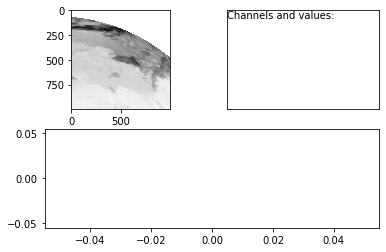

In [29]:
fig, ax = plt.subplots(2,2)

ax[0,1].grid(False)
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[1,1].remove()

gs      = gridspec.GridSpec(2,2)
ax[1,0] = plt.subplot(gs[1,:])
textbox = 'Channels and values:'
ax[0,1].text(0.0,1.0,textbox, fontsize=10, verticalalignment='top')

band = T_rad[8]

im   = band

x    = np.array([0, 1, 2, 3 ])
y    = np.array([3, 8, 1, 10])

implot = ax[0,0].imshow(im, cmap='Greys_r')

ax[1,0].plot([0,0,0], [0,0,0])

def onclick(event):
   if event.xdata != None and event.ydata != None:
       x = event.xdata
       y = event.ydata
       # We need to select a single layer (channel) from the 3-D array: 
       t = T_rad[:,int(y),int(x)]
       round = np.around(t, 11) 

       # text =============================================================== #
       # Clear axis
       ax[0,1].clear()
       ax[0,1].grid(False)
       ax[0,1].set_xticks([])
       ax[0,1].set_yticks([])

       # Write new text
       textbox = 'Wavelength [\u00b5m]             Temp (\N{DEGREE SIGN}C)'  + \
        '  \n' + '----------------------------------------------------------'  + \
        '  \n' + '         0.6                         ' + "{:.2f}".format(round[0]) + \
        '  \n' + '         0.8                         ' + "{:.2f}".format(round[1]) + \
        '  \n' + '         1.6                         ' + "{:.2f}".format(round[2]) + \
        '  \n' + '         3.9                         ' + "{:.2f}".format(round[3]) + \
        '  \n' + '         6.2                         ' + "{:.2f}".format(round[4]) + \
        '  \n' + '         7.3                         ' + "{:.2f}".format(round[5]) + \
        '  \n' + '         8.7                         ' + "{:.2f}".format(round[6]) + \
        '  \n' + '         9.7                         ' + "{:.2f}".format(round[7]) + \
        '  \n' + '         10.8                       '  + "{:.2f}".format(round[8]) + \
        '  \n' + '         12.0                       '  + "{:.2f}".format(round[9]) + \
        '  \n' + '         13.4                       '  + "{:.2f}".format(round[10])

       ax[0,1].text(0.04,0.95,textbox, fontsize=10, verticalalignment='top')

       # ==================================================================== #
       # Lines ============================================================== #
       # Lines remove

       ax[1,0].lines.remove(ax[1,0].lines[0])
    
       # Draw new lines
       ax[1,0].plot([0.6,0.8,1.6,3.9,6.2,7.3,8.7,9.7,10.8,12,13.4], t, color='black', marker='o', linestyle='dashed')
       ax[1,0].set_xlabel('Wavelength [\u00b5m]')
       ax[1,0].set_ylabel('Irradiance [mW m$^{-2}$ (cm$^{-1}$)$^{-1}$]') # mW m-2 sr-1 (cm-1)-1

       # ==================================================================== #

       plt.draw()

cid = fig.canvas.mpl_connect('button_press_event', onclick)

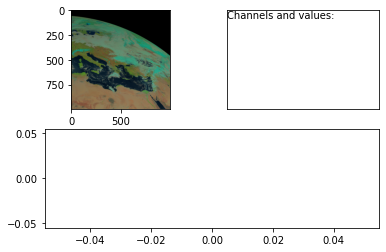

In [30]:
# -*- coding: utf-8 -*-

"""

Created on Mon Mar 22 09:18:51 2021
https://stackoverflow.com/questions/15721094/detecting-mouse-event-in-an-image-with-matplotlib
@author: dhelman-lab {new 2 - change display color to grey}

=================================================================================
==========    This code displays the TB of each channel instead of Irr   ========
=================================================================================
1) displays RGB day natural color image (from Irr - CH3, CH2, CH1 = R, G, B)
2) removes first 3 bands from the graph
=================================================================================
=================================================================================
=================================================================================

"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.visualization import make_lupton_rgb

fig, ax = plt.subplots(2,2)

ax[0,1].grid(False)
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[1,1].remove()

gs      = gridspec.GridSpec(2,2)
ax[1,0] = plt.subplot(gs[1,:])
textbox = 'Channels and values:'
ax[0,1].text(0.0,1.0,textbox, fontsize=10, verticalalignment='top')

r1 = sub_data[2]
g1 = sub_data[1]
b1 = sub_data[0]

im = make_lupton_rgb(r1, g1, b1)

implot = ax[0,0].imshow(im, cmap='Greys_r')

ax[1,0].plot([0,0,0], [0,0,0])

def onclick(event):
   if event.xdata != None and event.ydata != None:
       x = event.xdata
       y = event.ydata
       # We need to select a single layer (channel) from the 3-D array: 
       t = T_rad[3:11,int(y),int(x)]
       round = np.around(t, 8) 

       # text =============================================================== #
       # Clear axis
       ax[0,1].clear()
       ax[0,1].grid(False)
       ax[0,1].set_xticks([])
       ax[0,1].set_yticks([])

       # Write new text
       textbox = 'Channel      Wavelength [\u00b5m]      Temp (\N{DEGREE SIGN}C)'  + \
        '  \n' + '----------------------------------------------------------'  + \
        '  \n' + 'CH04                     3.9                   ' + "{:.2f}".format(round[0]) + \
        '  \n' + 'CH05                     6.2                   ' + "{:.2f}".format(round[1]) + \
        '  \n' + 'CH06                     7.3                   ' + "{:.2f}".format(round[2]) + \
        '  \n' + 'CH07                     8.7                   ' + "{:.2f}".format(round[3]) + \
        '  \n' + 'CH08                     9.7                   ' + "{:.2f}".format(round[4]) + \
        '  \n' + 'CH09                     10.8                 '  + "{:.2f}".format(round[5]) + \
        '  \n' + 'CH10                     12.0                 '  + "{:.2f}".format(round[6]) + \
        '  \n' + 'CH11                     13.4                 '  + "{:.2f}".format(round[7]) #+ \
        #'  \n' + '-----------------------------------------------------------' + \
        #'  \n' + 'SST                      '

       ax[0,1].text(0.04,0.95,textbox, fontsize=10, verticalalignment='top')

       # ==================================================================== #
       # Lines ============================================================== #
       # Lines remove

       ax[1,0].lines.remove(ax[1,0].lines[0])
    
       # Draw new lines
       ax[1,0].plot([3.9,6.2,7.3,8.7,9.7,10.8,12,13.4], t, color='black', marker='o', linestyle='dashed')
       ax[1,0].set_xlabel('Wavelength [\u00b5m]')
       ax[1,0].set_ylabel('Irradiance [mW m$^{-2}$ (cm$^{-1}$)$^{-1}$]') # mW m-2 sr-1 (cm-1)-1

       # ==================================================================== #

       plt.draw()

cid = fig.canvas.mpl_connect('button_press_event', onclick)